# PSF Extractor
---

#### Overview
1. Initialize parameters
2. Create stack
3. Find features
4. Mass-based (brightness) filtering
5. Filter out overlapping features
6. Extract PSFs
7. Filter out strange PSFs
8. Localize PSFs
9. Characterize PSF

#### Libraries

In [1]:
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

#### Log settings

In [2]:
import logging
logging.getLogger().setLevel(logging.INFO)

## 1) Initialize parameters
---

Expected feature diameters in $x$, $y$, and optionally $z$ are needed for initial feature detection with `trackpy.locate`. These can either be provided or estimated from known optical parameters such as the numerical aperture, emission wavelength, and pixel size.

In [3]:
# Set pixel sizes [nm/px]
psx = 108
psy = psx
psz = 300

# Set optical parameters:
NA = 0.95  # numerical aperture
lambda_em = 520  # emission wavelength

# Set expected feature diameters [nm]
dx_nm = lambda_em / NA 
dy_nm = dx_nm
dz_nm = 3*dx_nm

# Convert expected feature diameters [nm --> px]
# and round up to nearest odd integer
dx = dx_nm / psx
dy = dy_nm / psy
dz = dz_nm / psz

# Round diameters up to nearest odd integer (as per `trackpy` instructions)
dx, dy, dz = np.ceil([dx, dy, dz]).astype(int) // 2 * 2 + 1

# Set PSF window
wx = 6 * dx   # px
wy = 6 * dy   # px
wz = 6 * dz  # px

# Output
out = f"""\
Optical settings
----------------
NA.............. {NA:.2f}
Wavelength...... {lambda_em:.0f} nm
Pixelsize x..... {psx:.1f} nm/px
Pixelsize y..... {psy:.1f} nm/px
Pixelsize z..... {psz:.1f} nm/px
Diameter x...... {dx:.0f} px ({dx_nm:.1f} nm)
Diameter y...... {dy:.0f} px ({dy_nm:.1f} nm)
Diameter z...... {dz:.0f} px ({dz_nm:.1f} nm)
PSF window x.... {wx:.0f} px ({wx*psx:.0f} nm)
PSF window y.... {wy:.0f} px ({wy*psy:.0f} nm)
PSF window z.... {wz:.0f} px ({wz*psz:.0f} nm)
"""
print(out)

Optical settings
----------------
NA.............. 0.95
Wavelength...... 520 nm
Pixelsize x..... 108.0 nm/px
Pixelsize y..... 108.0 nm/px
Pixelsize z..... 300.0 nm/px
Diameter x...... 7 px (547.4 nm)
Diameter y...... 7 px (547.4 nm)
Diameter z...... 7 px (1642.1 nm)
PSF window x.... 42 px (4536 nm)
PSF window y.... 42 px (4536 nm)
PSF window z.... 42 px (12600 nm)



#### Spicy colormap

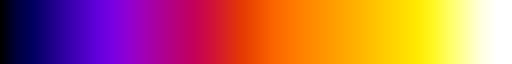

In [4]:
from psf_extractor.util import get_Daans_special_cmap
fire = get_Daans_special_cmap()
fire

In [5]:
import trackpy
from psf_extractor import load_stack, plot_mip

## 2) Create stack
---

In [6]:
# Set directory of image stack
file_pattern = '../data/sample2_zstack_tif_sequence/'
# Load image stack
stack = load_stack(file_pattern)

INFO:root:Creating stack from directory.


  0%|          | 0/34 [00:00<?, ?it/s]

INFO:root:(34, 2048, 2048) image stack created succesfully.


## 3) Find features
---
The first step in the workflow is to detect features (e.g. fluorescent beads) within a 3D image stack. Features are found using `trackpy.locate`, which takes the image stack and expected feature diameters as input. No constraints are provided to `trackpy.locate` such that it returns all possible features on the scale of the expected feature dimensions. We then go through a series of filtering steps to end up with a feature set that ought to be single PSF localizations.

#### Maximum intensity projection in `z`

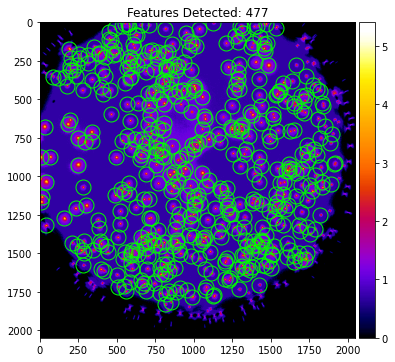

In [7]:
# Get MIP
mip = np.max(stack, axis=0)

# Locate features
features_init = trackpy.locate(mip, diameter=[dy, dx]).reset_index(drop=True)

# Plot MIP
plot_mip(mip, features=features_init)

## 4) Mass-based filtering
---

The mass is the "integrated brightness" of a feature. It is important to choose reasonable lower and upper bounds to filter out spurious features (salt) smaller than the PSF and clusters larger than the PSF. It's difficult to know these bounds _a priori_, as the appropriate bounds will vary from dataset to dataset. So it is useful to sample a logarithmic range of candidate bounds and choose proper minimum and maximum masses based on visual inspection.

In [8]:
from ipywidgets import interact, fixed, FloatLogSlider
from psf_extractor import get_min_masses, get_max_masses, plot_mass_range_interactive

#### Choose minimum mass

In [9]:
# Choose minimum mass range
min_masses = get_min_masses(mip, dx=dx, n=35, b=20)

# Interactive plot
widget = interact(plot_mass_range_interactive,
                  mip=fixed(mip),
                  mass=FloatLogSlider(value=np.median(min_masses),
                                      min=np.log10(min_masses.min()),
                                      max=np.log10(min_masses.max())),
                  features=fixed(features_init),
                  filtering=fixed('min'));

interactive(children=(FloatLogSlider(value=7.593356329610143, description='mass', max=2.1814637759386293, min=…

In [10]:
# Set minimum mass
min_mass = widget.widget.children[0].value

#### Choose maximum mass

In [11]:
# Get candidate maximum masses
max_masses = get_max_masses(min_mass, n=31, b=20)

widget = interact(plot_mass_range_interactive,
                  mip=fixed(mip),
                  mass=FloatLogSlider(value=np.median(max_masses),
                                      min=np.log10(max_masses.min()),
                                      max=np.log10(max_masses.max())),
                  features=fixed(features_init.loc[features_init['raw_mass'] > min_mass]),
                  filtering=fixed('max'));

interactive(children=(FloatLogSlider(value=10.713096029389627, description='mass', max=1.6804299956639812, min…

In [12]:
# Set minimum mass
max_mass = widget.widget.children[0].value

# Update feature set
features_mass = features_init.loc[(features_init['raw_mass'] > min_mass) &\
                                  (features_init['raw_mass'] < max_mass)]

# Output
out = f"""\
Minimum mass................ {min_mass:.2f}
Maximum mass................ {max_mass:.2f}
Initial features............ {len(features_init):.0f}
Too dim (min filtered)...... {len(features_init.loc[features_init['raw_mass'] < min_mass]):.0f}
Too bright (max filtered)... {len(features_init.loc[features_init['raw_mass'] > max_mass]):.0f}
Remaining features.......... {len(features_mass):.0f}
Random sample of features...
"""
print(out)
features_mass.sample(5)

Minimum mass................ 2.40
Maximum mass................ 15.11
Initial features............ 477
Too dim (min filtered)...... 2
Too bright (max filtered)... 3
Remaining features.......... 472
Random sample of features...



,y,x,mass,size,ecc,signal,raw_mass,ep
35,157.769488,484.875278,1.242432,1.509067,0.103834,0.134205,4.843049,0.008849
278,1095.999043,1767.415311,1.445815,1.682161,0.206947,0.127287,6.771300,0.006222
112,430.067217,1294.277123,1.173254,1.547975,0.140504,0.121753,4.856503,0.008823
350,1367.162544,1291.245583,0.783092,1.632813,0.078222,0.073328,3.753363,0.011623
139,523.320951,1651.233284,0.931132,1.588873,0.133973,0.092698,4.071749,0.010648


## 5) Filter out overlapping and edge features
---

Overlapping PSFs must be removed so that they do not distort the PSF characterization. To remove them, a virtual bounding box is created around each feature and checked for overlap against every other feature's bounding box. PSFs along the edge of the stack are likewise removed.

In [13]:
from psf_extractor import detect_overlapping_features, detect_edge_features, plot_overlapping_features

  0%|          | 0/24 [00:00<?, ?it/s]

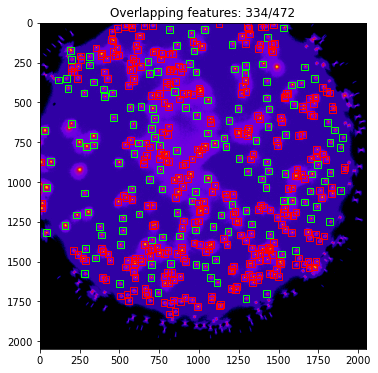

In [14]:
# Detect overlapping features
overlapping = detect_overlapping_features(features_mass, wx, wy)
# Detect edge features
Dz, Dy, Dx = stack.shape  # stack boundaries
edges = detect_edge_features(features_mass, Dx, Dy, wx, wy)
# Combine
overlapping = np.concatenate([overlapping, edges])

# Plot overlapping and edge features
plot_overlapping_features(mip, features_mass, overlapping, wx, wy)

In [15]:
# Update feature set
features_overlap = features_mass.loc[~features_mass.index.isin(overlapping)]

# Output
out = f"""\
Initial features............ {len(features_mass):.0f}
Overlapping features........ {overlapping.size:.0f}
Remaining features.......... {len(features_overlap):.0f}
Random sample of features...
"""
print(out)
features_overlap.sample(5)

Initial features............ 472
Overlapping features........ 334
Remaining features.......... 142
Random sample of features...



,y,x,mass,size,ecc,signal,raw_mass,ep
253,981.272441,1392.592126,0.878557,1.640050,0.091620,0.081630,4.008969,0.010827
439,1598.741304,1071.208696,0.636435,1.690768,0.071117,0.055342,3.098655,0.014320
349,1363.431925,702.256651,0.884091,1.641595,0.044454,0.084397,4.044843,0.010724
449,1636.914634,500.034843,0.794160,1.614935,0.039419,0.074712,3.591928,0.012189
41,177.103990,969.189843,1.144200,1.516934,0.136980,0.123136,4.605381,0.009335


## 6) Extract PSFs
---

All of the filtered PSFs must be extracted before they can be aligned and averaged. We already have the rough coordinates of each PSF from filtering the features detected by `trackpy.locate`. So we simply define a subvolume containing the PSF and extract.

In [18]:
from psf_extractor import extract_psfs, plot_psfs

#### Define subvolume and extract PSFs

In [19]:
# Extract PSFs
psfs = extract_psfs(stack, features=features_overlap, shape=(wz, wy, wx))

#### Plot the maximum intensity projection of each extracted PSF

  0%|          | 0/142 [00:00<?, ?it/s]

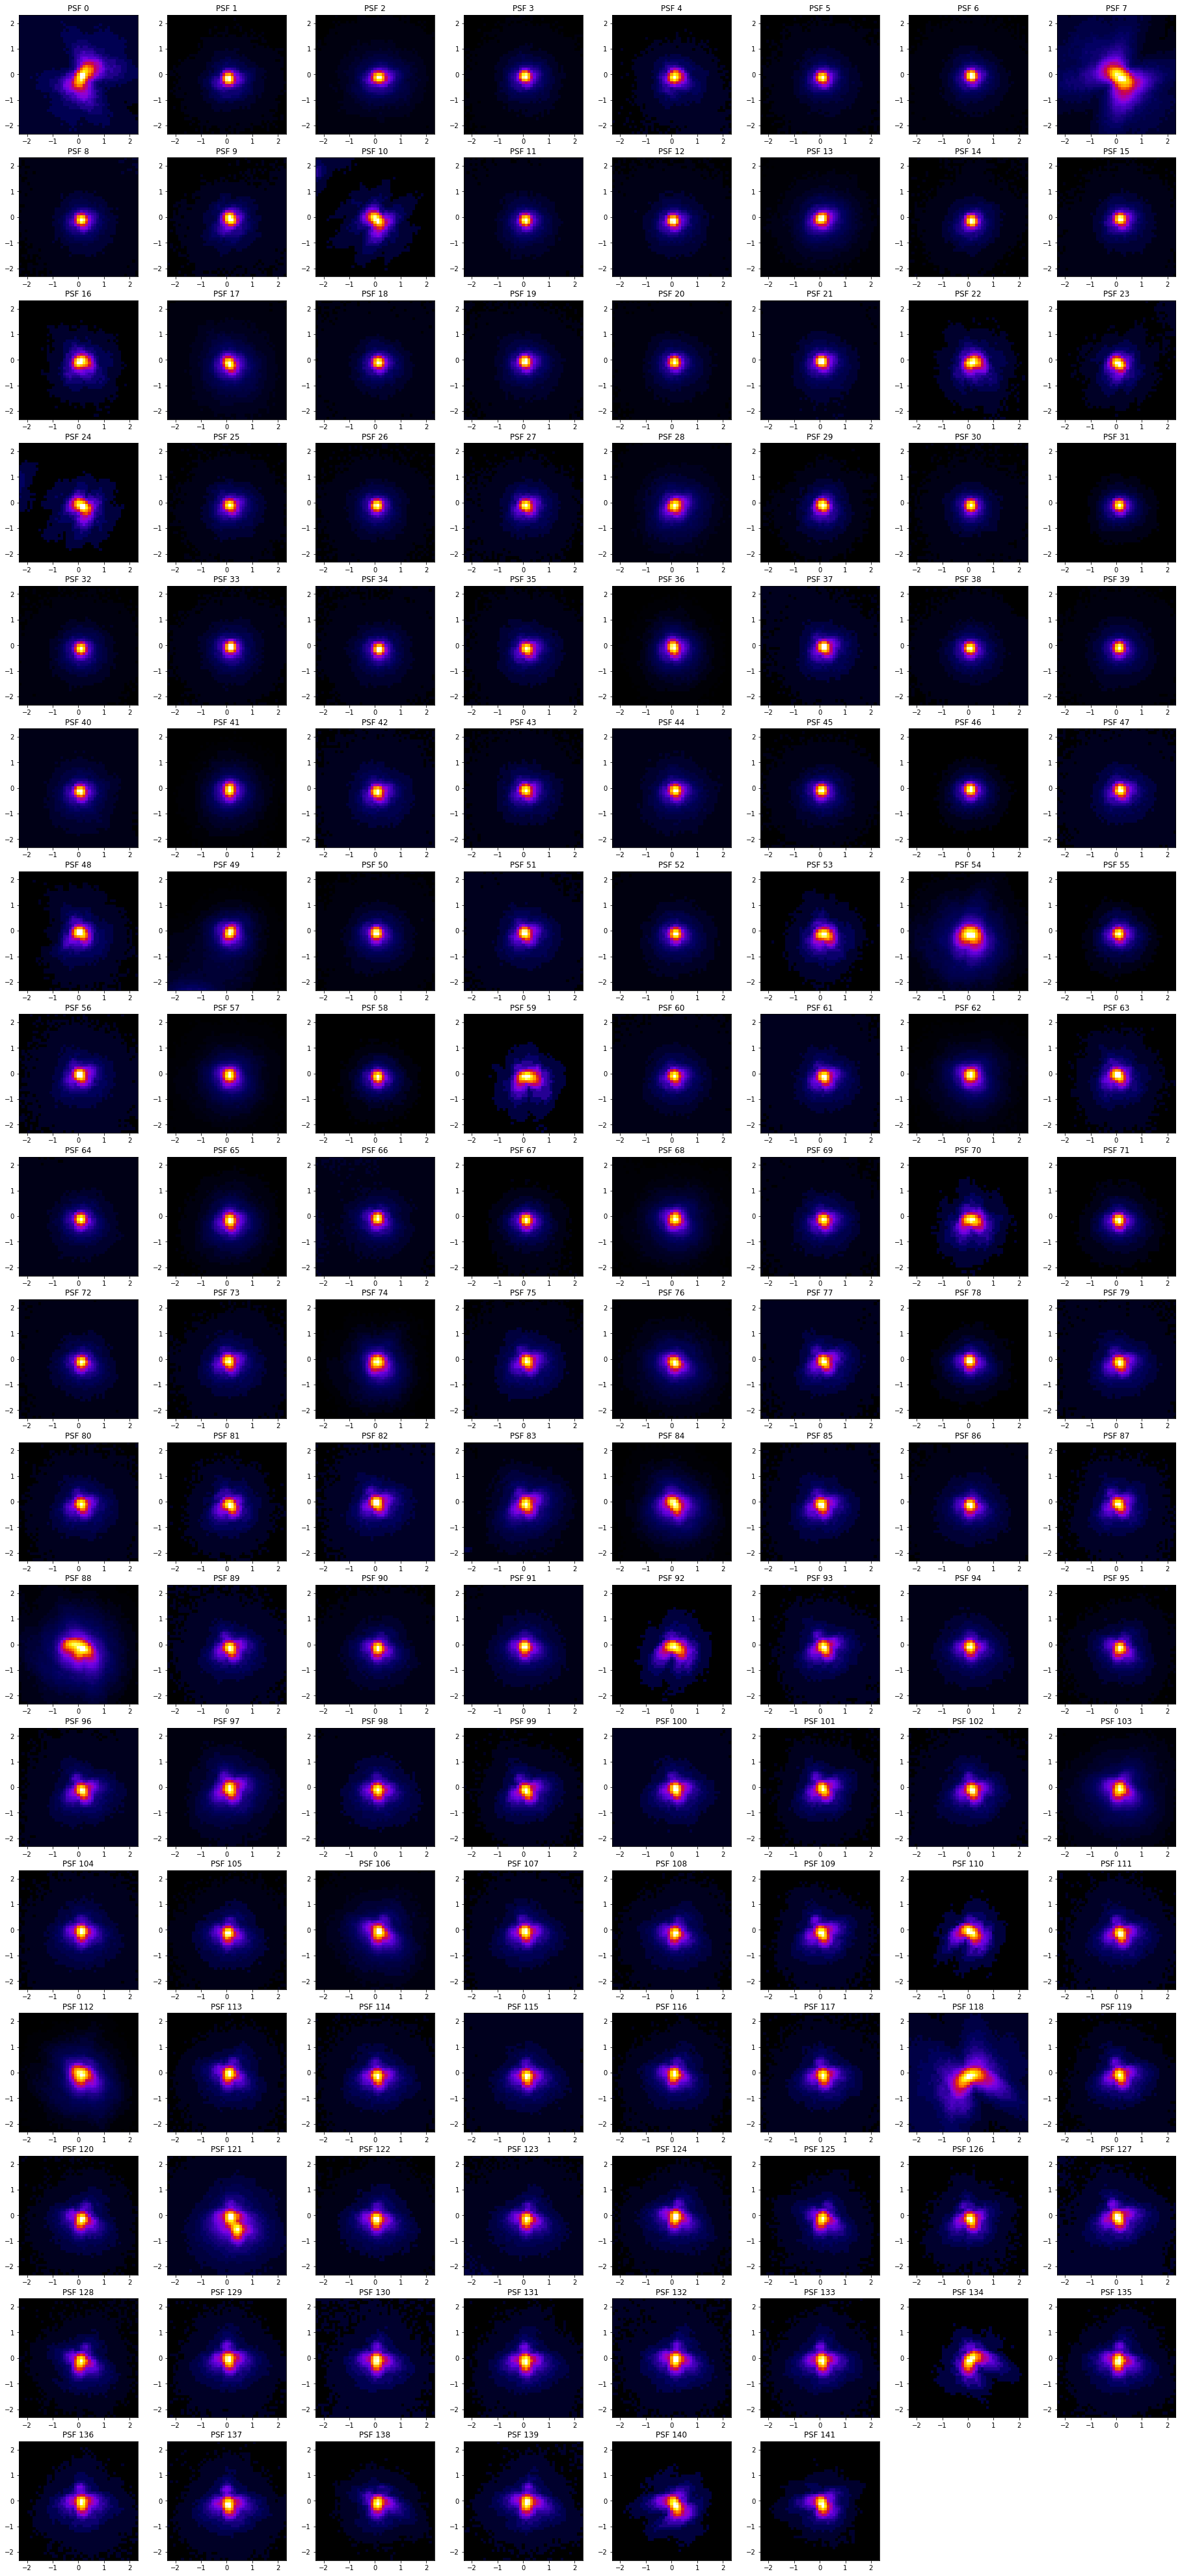

In [20]:
# Plot PSF MIPs
plot_psfs(psfs, psx, psy)

## 7) Filter out strange PSFs
---

Use the Pearson correlation coefficient to filter out oultier PSFs. Each PSF is compared to every other PSF. Outlier criteria is based on a PSF having a PCC that frequently falls below 0.9. Why 0.9? Would you be satisfied with less than an "A"? Didn't think so...

Why isn't once enough? Because it takes 2 PSFs to generate a wild PCC value. One of these PSFs may be totally fine, but the only way to tell a typical PSF from an outlier is by checking the number of occurences each PSF falls in the outlier range.

How many times is frequently? A bit arbitrary, but 3× the average number of occurences seems to work empirically.

In [21]:
from psf_extractor import detect_outlier_psfs, plot_pcc_distribution

In [22]:
# Set minimum PCC threshold
pcc_min = 0.93

# Detect outlier PCCs
outliers_, pccs = detect_outlier_psfs(psfs, pcc_min=pcc_min, return_pccs=True)

# Stupid index trick thingy
df = features_overlap.reset_index()
outliers = df[df.index.isin(outliers_)]['index'].values

  0%|          | 0/10011 [00:00<?, ?it/s]

#### Plot distribution of Pearson correlation coefficients

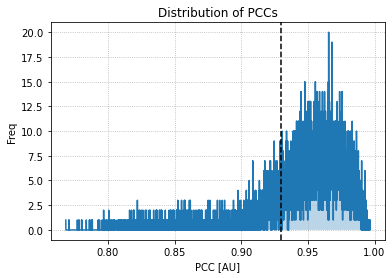

In [23]:
plot_pcc_distribution(pccs, pcc_min=pcc_min, bins=pccs.size//2)

In [24]:
# Update feature set
features_pearson = features_overlap.loc[~features_overlap.index.isin(outliers)]

# Output
out = f"""\
Initial features............ {len(features_overlap):.0f}
Outlier features............ {outliers.size:.0f}
Remaining features.......... {len(features_pearson):.0f}
Random sample of features...
"""
print(out)
features_pearson.sample(5)

Initial features............ 142
Outlier features............ 7
Remaining features.......... 135
Random sample of features...



,y,x,mass,size,ecc,signal,raw_mass,ep
346,1346.413474,769.631440,1.047351,1.644012,0.053588,0.098232,4.780269,0.008973
41,177.103990,969.189843,1.144200,1.516934,0.136980,0.123136,4.605381,0.009335
190,750.622375,246.937848,3.227833,1.645891,0.046685,0.289163,13.681614,0.003014
135,484.800759,1053.751423,2.187400,1.618598,0.077086,0.208917,9.116591,0.004571
195,767.814534,338.946855,1.275637,1.522784,0.083763,0.134205,5.273542,0.008087


## 8) Localize PSFs
---

The individual PSF positions must be localized with subpixel accuracy in $x$, $y$, and $z$. First, we fit a 2D Gaussian to each PSF in the maximum intensity projection to get the $x$, $y$ position. Then we fit a 1D Gaussian to the line profile through the center of the PSF to get the $z$ position.

* 2D Gaussian fit for $x$, $y$ localization 
* 1D Gaussian fit for $z$ localization
  * Might it be better to sum/integrate in x, y?

In [25]:
from psf_extractor import localize_psfs, plot_psf_localizations

In [26]:
# Re-extract PSFs based on updated feature set
psfs = extract_psfs(stack, features=features_pearson, shape=(wz, wy, wx))

# Localize PSFs
locations = localize_psfs(psfs, integrate=False)
locations.head()

  0%|          | 0/135 [00:00<?, ?it/s]

,x0,y0,z0,sigma_x,sigma_y,sigma_z
0,21.758935,22.537227,16.954117,1.847113,1.800029,1.08671
1,22.494972,22.122954,16.928048,2.19391,1.732736,1.154584
2,21.769326,21.784936,16.918026,1.799377,1.719896,1.032513
3,22.27178,21.955681,16.647774,2.18686,1.997463,1.171019
4,21.956521,22.222077,16.807258,1.854705,1.768381,1.05653


#### Plot localization data

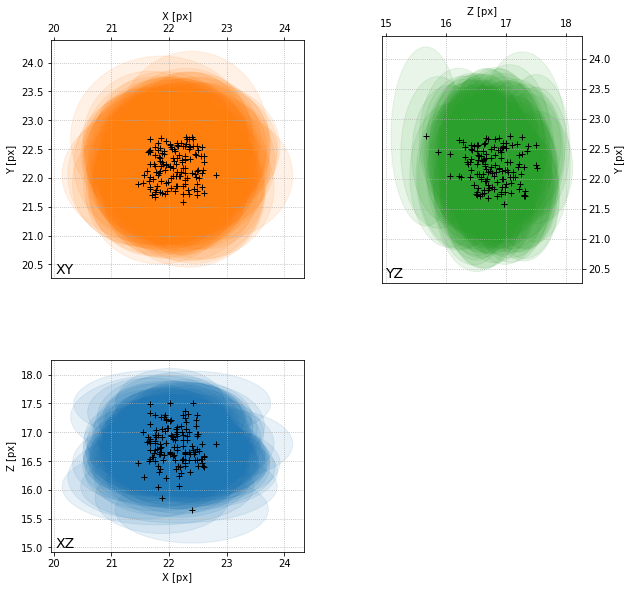

In [27]:
plot_psf_localizations(locations)

## 9) Characterize PSF
---

Upsample and align PSFs

#### Upsample and align PSFs

In [28]:
from psf_extractor import align_psfs, crop_psf, plot_psf

In [29]:
# Set upsample factor
usf = 5

# Align PSFs
psf_sum = align_psfs(psfs, locations, upsample_factor=usf)

  0%|          | 0/135 [00:00<?, ?it/s]

#### Plot PSF

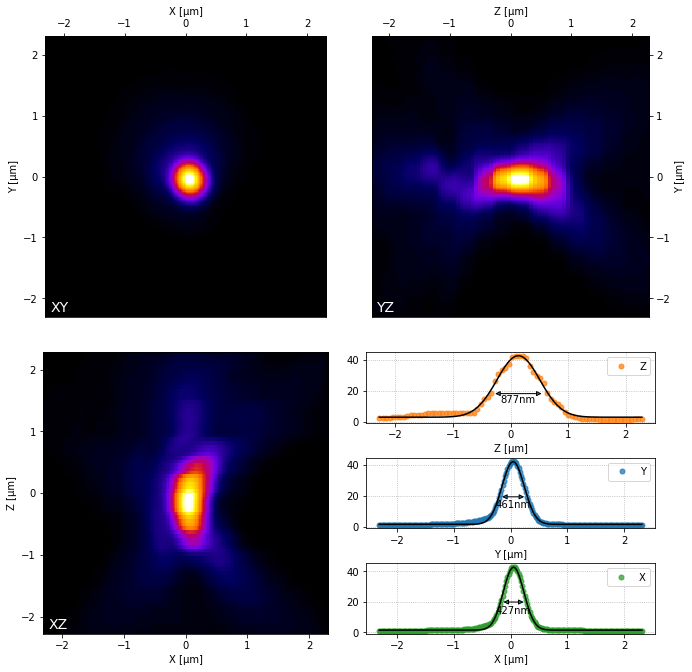

In [30]:
# Crop PSF
psf_sum = crop_psf(psf_sum, psx, psy, psz)

# Plot PSF
plot_psf(psf_sum, psx/usf, psy/usf, psz/usf)